In [1]:
from src import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

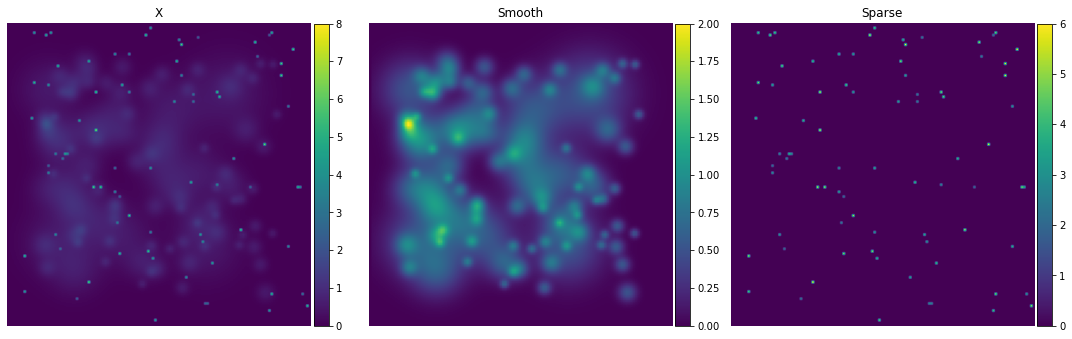

In [3]:
d = (128, 128)
seed = 11
s = SparseSmoothSignal(d)
s.random_sparse(seed)
s.random_smooth(seed)
s.plot()

In [14]:
L = 0.1
l1 = 0.02
l2 = 0.01
psnr = 50.
s.psnr = psnr
s.H = get_best_freq_operator(s, L)

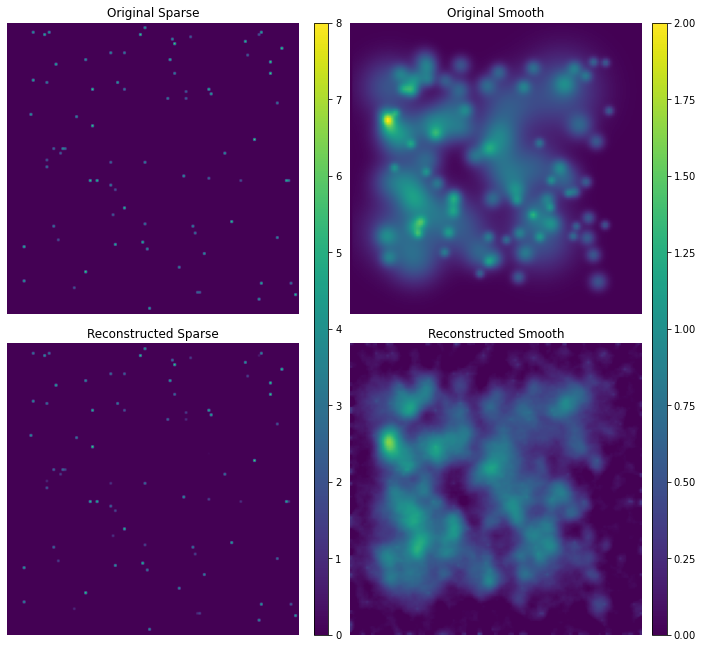

In [15]:
x1, x2 = solve(s, l1, l2, get_L2_operator(d, "Laplacian"))
plot_reconstruction(s.sparse, s.smooth, x1, x2)

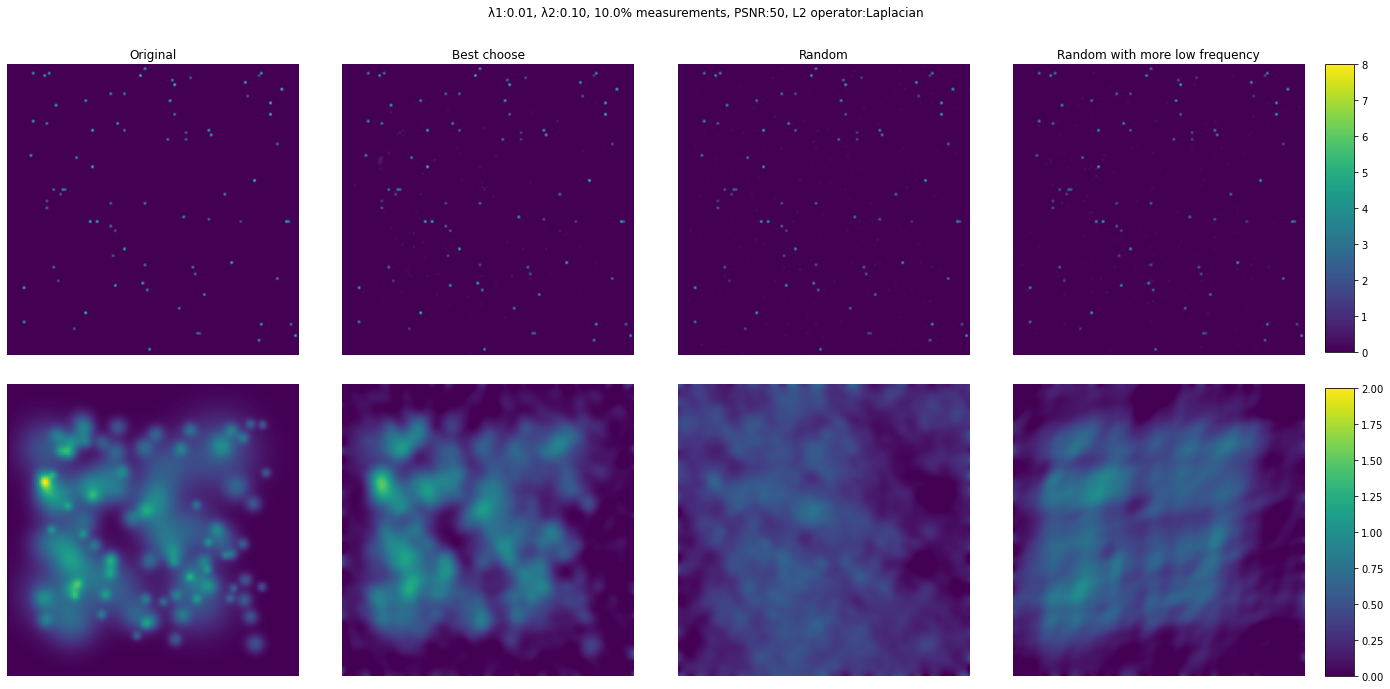

In [6]:
compare_choice_of_measurements(s, L, l1, l2, psnr, "Laplacian")

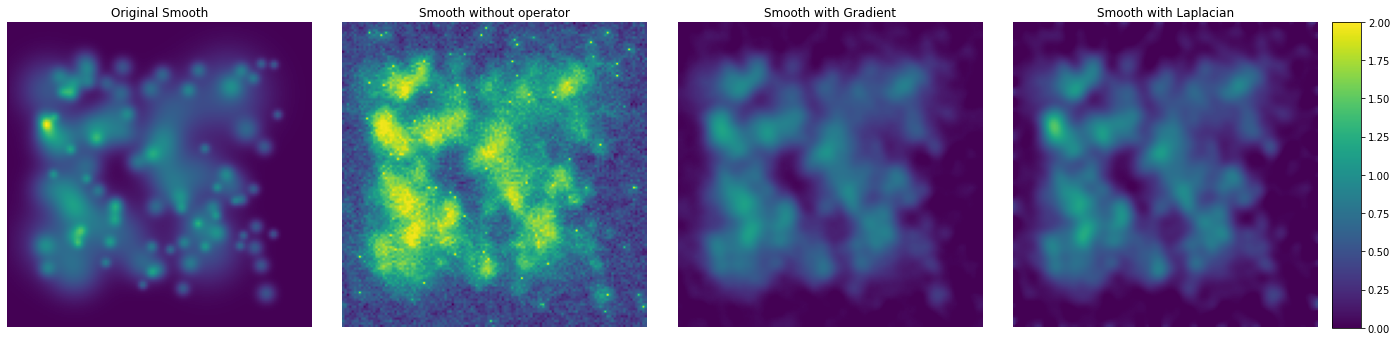

In [7]:
compare_smoothing_operator(s)

Sparse:
λ1:0.05, λ2:0.20, 10.0% measurements, PSNR:50, L2 operator:Laplacian : 7.701765101814828e-06
λ1:0.05, λ2:0.10, 10.0% measurements, PSNR:50, L2 operator:Laplacian : 7.868186843789636e-06
λ1:0.01, λ2:0.10, 10.0% measurements, PSNR:50, L2 operator:Laplacian : 1.3607452408246448e-05
λ1:0.01, λ2:0.20, 10.0% measurements, PSNR:50, L2 operator:Laplacian : 6.31896558607645e-05
Smooth:
λ1:0.05, λ2:0.10, 10.0% measurements, PSNR:50, L2 operator:Laplacian : 0.01991203395545164
λ1:0.01, λ2:0.10, 10.0% measurements, PSNR:50, L2 operator:Laplacian : 0.020184466805941343
λ1:0.05, λ2:0.20, 10.0% measurements, PSNR:50, L2 operator:Laplacian : 0.02020176262282424
λ1:0.01, λ2:0.20, 10.0% measurements, PSNR:50, L2 operator:Laplacian : 0.02755955626600751


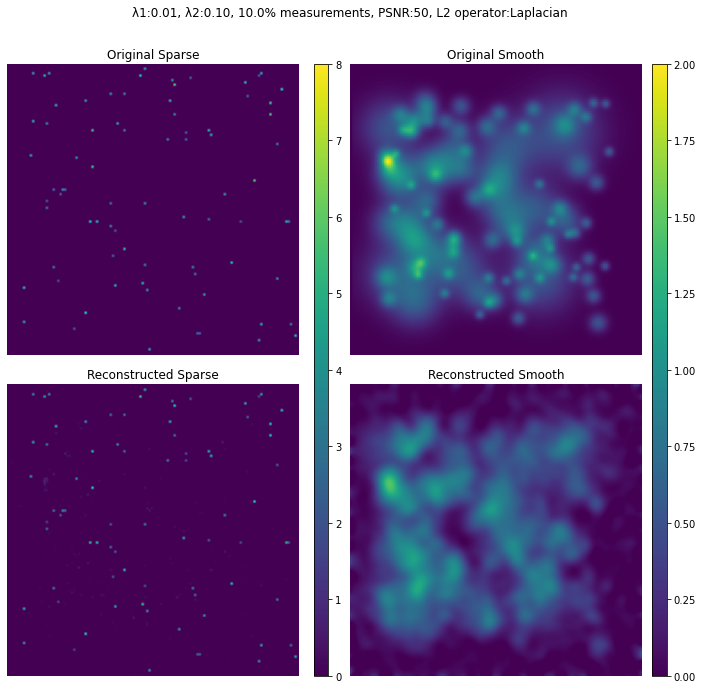

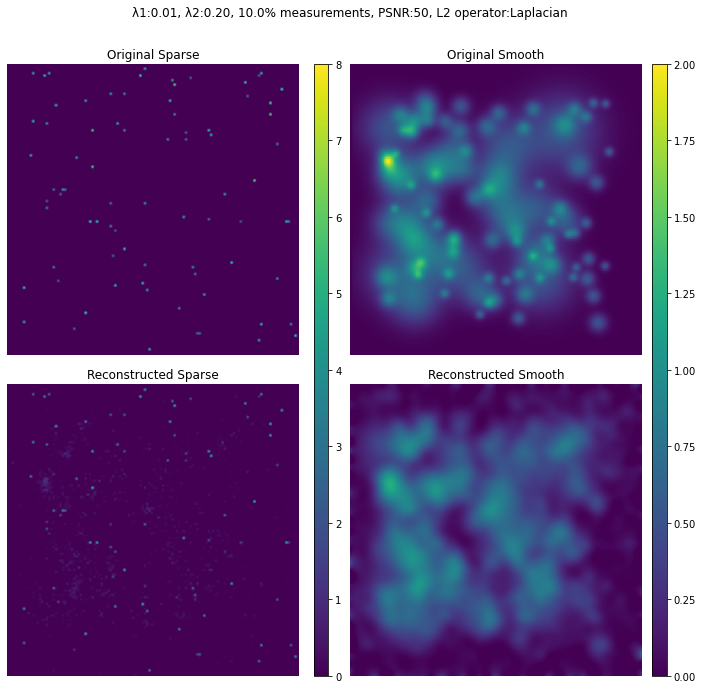

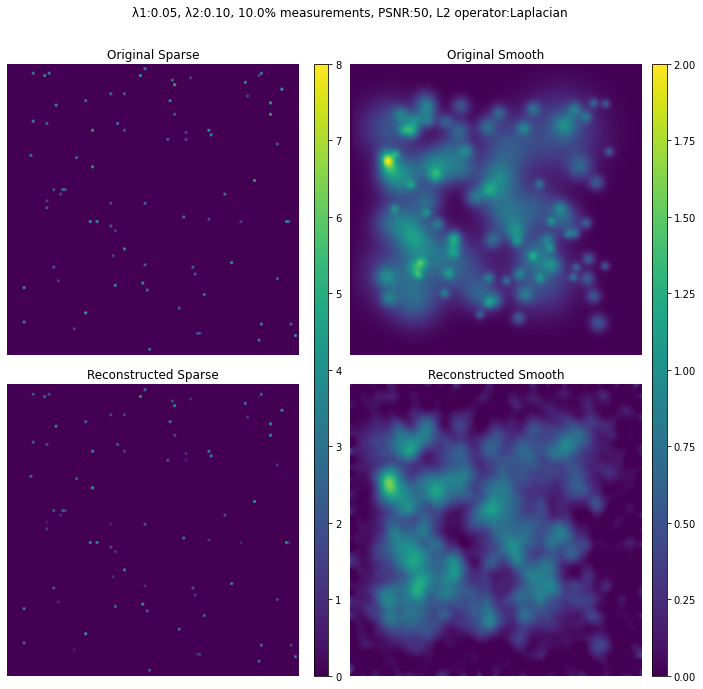

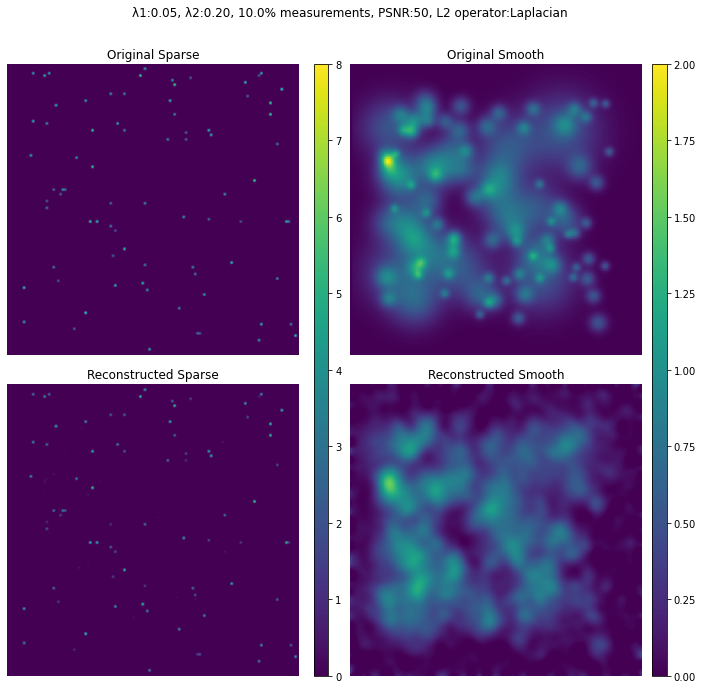

In [8]:
test_hyperparameters(s, L, [0.01, 0.05], [0.1, 0.2], ["Laplacian"], [psnr])

Best value for L1 penalty: 0.021306122448979593
Best value for L2 penalty: 0.025367346938775515


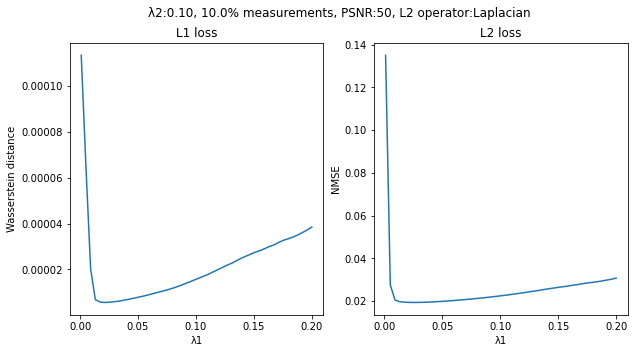

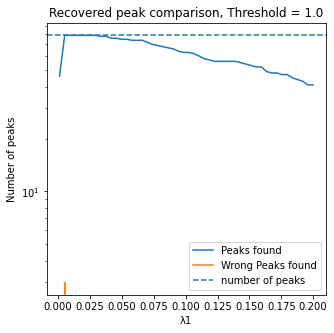

In [9]:
test_lambda1(s, L, lambda1_min=0.001, lambda1_max=0.2, nb=50, lambda2=0.1, operator_l2="Laplacian", psnr=50.)

Best value L1: 0.05379591836734694
Best value L2: 0.03348979591836735


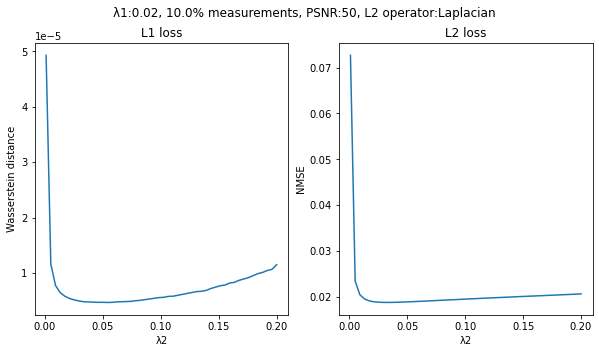

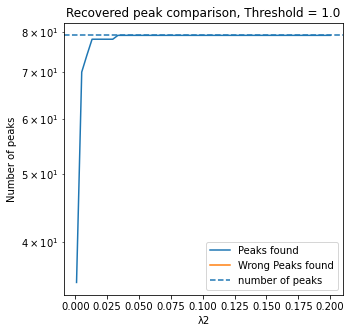

In [13]:
test_lambda2(s, L, lambda2_min=0.001, lambda2_max=0.2, nb=50, lambda1=0.02, operator_l2="Laplacian", psnr=50.)